In [15]:
import os
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import io
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
#Need to hardcode the location so Jupyter can find the files
train_set = 'C:/Users/David/Desktop/Tensorflow/UNSW Data/UNSW_NB15_training-set.csv'
test_set = 'C:/Users\David/Desktop/Tensorflow/UNSW Data/UNSW_NB15_testing-set.csv'

training = pd.read_csv(train_set, index_col='id')
test = pd.read_csv(test_set, index_col='id')

data = pd.concat([training, test]) # Just merging the sets for now as training doesn't match test columns when ONEHOT
                                   # And this is just easier for now when testing stuff
                                   
data_cols = data.columns.drop('label')
data = data[data_cols]

In [17]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [18]:
##Looking for attack_cat
CATEGORICAL_COLUMNS = ['proto', 'service', 'state']
NUMERIC_COLUMNS = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload',
                   'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb',
                   'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
                   'response_body_len', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
                   'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
                   'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_sm_ips_ports']

for col in CATEGORICAL_COLUMNS:
    encode_text_dummy(data, col)

for col in NUMERIC_COLUMNS:
    encode_numeric_zscore(data, col)

training.dropna(inplace=True, axis=1)
test.dropna(inplace=True, axis=1)
print(training[0:5])

         dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
id                                                                          
1   0.121478   tcp       -   FIN      6      4     258     172  74.087490   
2   0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
3   1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
4   1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
5   0.449454   tcp       -   FIN     10      6     534     268  33.373826   

    sttl  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
id        ...                                                               
1    252  ...                 1               1             0           0   
2     62  ...                 1               2             0           0   
3     62  ...                 1               3             0           0   
4     62  ...                 1               3             1           1  

In [19]:
x_columns = data.columns.drop('attack_cat')
x = data[x_columns].values
dummies = pd.get_dummies(data['attack_cat'])  # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42)


C:\Users\David\Anaconda3\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[1.31945324e-02 8.00582632e-03 7.74040054e-03 2.98156790e-02
 8.64863029e-03 1.84282562e-02 6.43088365e-02 3.84932894e-02
 2.24211067e-02 3.37342835e-02 5.98327254e-03 8.41050970e-03
 1.74168046e-02 9.62500745e-03 1.20915220e-02 1.09658538e-02
 1.51210831e-02 8.14724515e-03 1.90659208e-02 3.15288672e-02
 1.15007476e-02 1.13333476e-02 8.84603803e-03 3.25314867e-02
 1.31707519e-02 1.56369872e-03 2.36764568e-03 3.27637190e-02
 4.57820813e-02 4.00742463e-02 4.56735891e-02 1.00026722e-02
 2.59477058e-02 5.16622051e-04 7.13343443e-04 3.36019390e-03
 1.08081249e-02 4.92803379e-02 3.39402149e-03 5.75761691e-06
 2.08576494e-06 7.12378749e-06 6.26939866e-05 1.93396965e-05
 1.46652926e-05 4.62433113e-03 8.40539628e-06 1.11530628e-05
 1.78782282e-05 6.71438836e-06 9.60070091e-06 4.39085120e-06
 3.93156093e-06 1.06466502e-05 3.38377209e-06 1.52692771e-05
 7.57039751e-06 6.36305839e-06 4.55065689e-06 4.21955444e-06
 8.65046225e-06 7.37161340e-06 3.57454431e-05 1.47244687e-05
 6.28216851e-06 3.530420

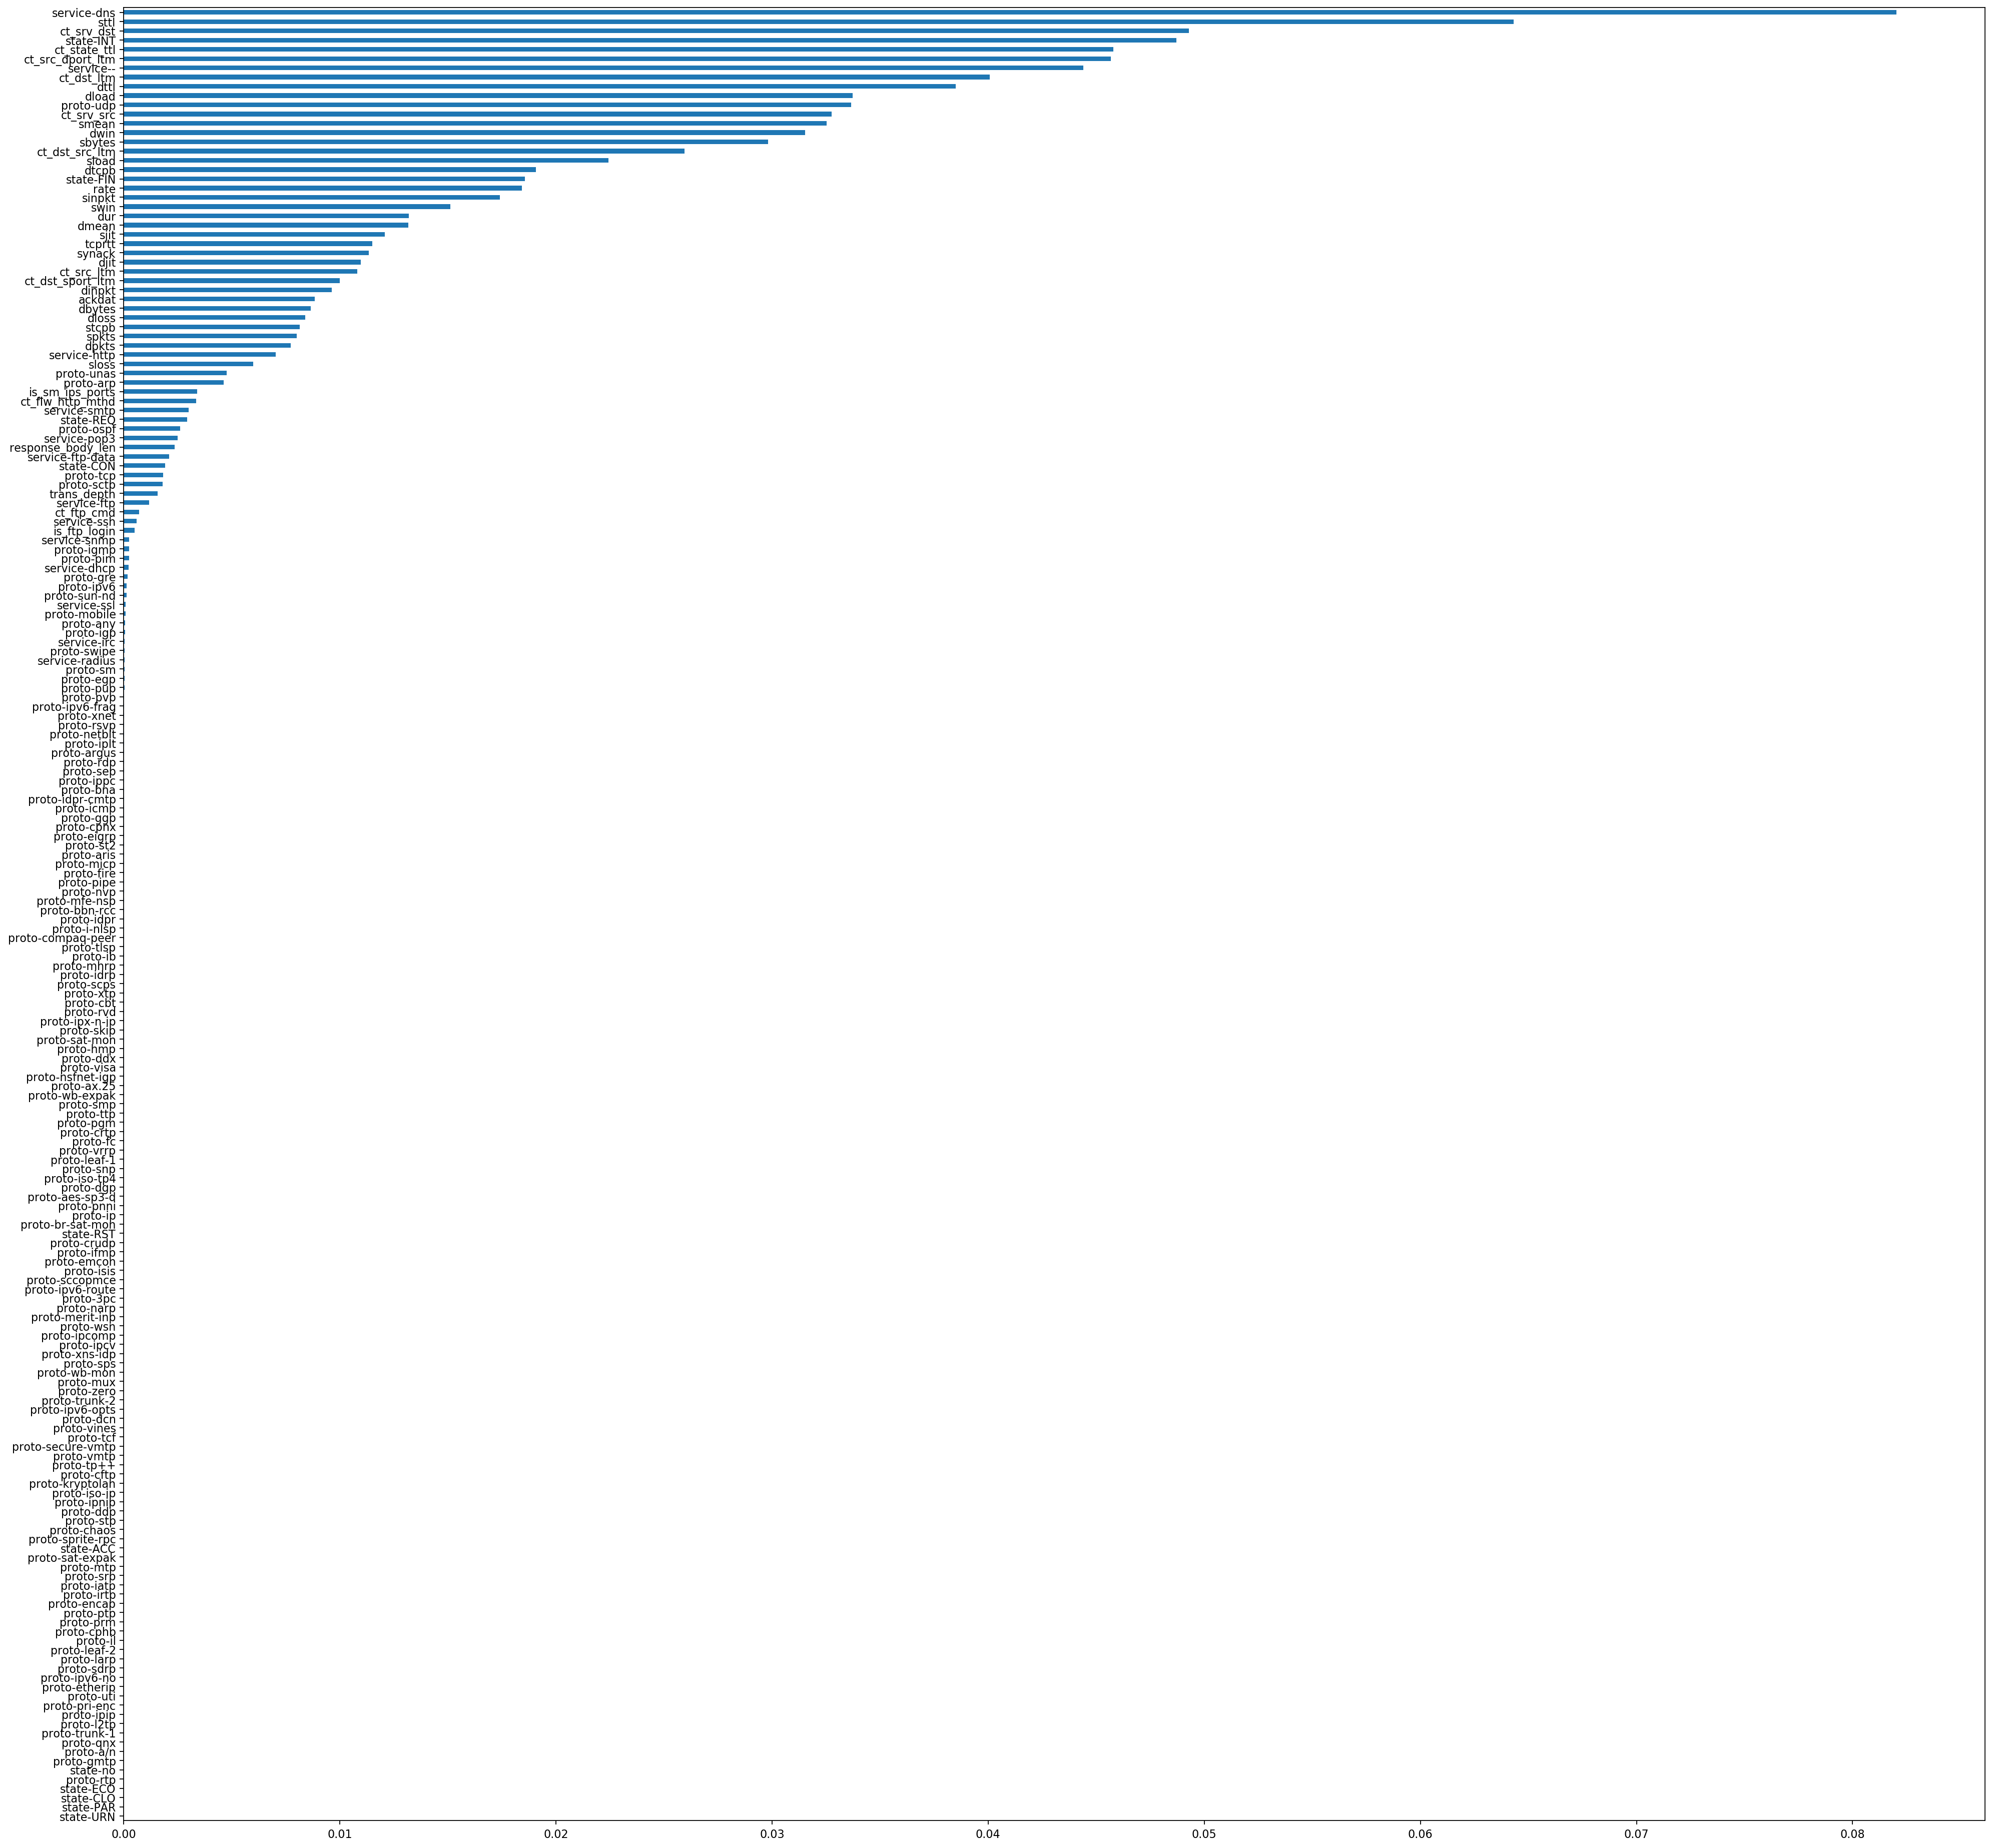

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, dpi=160, figsize=(30,30), facecolor='w', edgecolor='k')
classifier = ExtraTreesClassifier()
classifier.fit(x,y)
print(classifier.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(classifier.feature_importances_, index=x_columns)
# top25 = feat_importances.nlargest(10).plot(kind='barh')
topimportance = feat_importances.sort_values().plot(kind='barh')
plt.savefig("C:/Users\David/Desktop/Tensorflow/UNSW Data/importance.png", dpi=160, bbox_inches='tight')
plt.show()

In [21]:
import seaborn as sns
#get correlations of each features in dataset
figure(num=None, dpi=160, figsize=(45,45), facecolor='w', edgecolor='k')
corrmat = data.corr()
top_corr_features = corrmat.index
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 6400x6400 with 0 Axes>

In [22]:
# New training based off accuracy
# As we now have the most important features, let's train a new model and add in more and more features based off importance and see affect on accuracy

In [23]:
def train_model(features, x, y):
    x = x[:, indexes]
    x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42)
    
    model = Sequential()
    model.add(Dense(15, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    # model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test,y_test),callbacks=[monitor], verbose=2, epochs=50)
    
    pred = model.predict(x_test)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))
    return (len(features), score)

In [26]:
featuresList = []
indexes = []
scores = []
feat_importances = feat_importances.iloc[::-1]
axes = feat_importances.axes
i = 0
test = feat_importances.nlargest(20).axes[0]
for feature in feat_importances.axes[0].values:
    featuresList.append(feature)
    feature_index = np.where(x_columns == feature)[0][0]
    indexes.append(feature_index)
    
    result = train_model(indexes, x, y)
    scores.append(result)
print(scores)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 15)                30        
_________________________________________________________________
dense_17 (Dense)             (None, 30)                480       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                110       
Total params: 930
Trainable params: 930
Non-trainable params: 0
_________________________________________________________________
None
Train on 219022 samples, validate on 38651 samples
Epoch 1/50
219022/219022 - 5s - loss: 1.7469 - val_loss: 1.6911
Epoch 2/50
219022/219022 - 5s - loss: 1.6893 - val_loss: 1.6909
Epoch 3/50
219022/219022 - 5s - loss: 1.6893 - val_loss: 1.6913
Epoch 

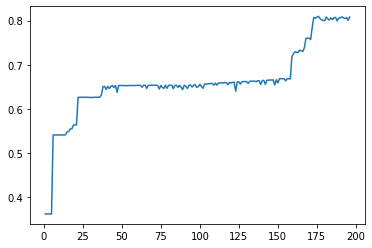

In [28]:
#Graph scores
scores = np.array(scores)
xaxis = scores[:, [0]]
yaxis = scores[:, [1]]
plt.plot(xaxis, yaxis)
plt.savefig("C:/Users\David/Desktop/Tensorflow/UNSW Data/scores.png", dpi=160, bbox_inches='tight')
plt.show()